Curso de Big Data
==============================

Trabajo práctico 4
------------------------------

### Grupo: Armas Braithwaite, Fernández, Menta, Vargas Ochuza

## Parte 1: Análisis de la base de hogares y cálculo de pobreza


In [1]:
# Importamos los módulos necesarios para trabajar con la base de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

### Inciso 1
Descarguen la base de microdatos de la EPH correspondiente al primer trimestre de 2023 (la base de hogares se llama usu hogar T123.xls). Importen los datos de la encuesta de hogar y, al igual que en los trabajos anteriores, conserven solo las observaciones que corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o del Gran Buenos Aires.

In [2]:
# Cargamos las bases
microdata_hogar = pd.read_excel("usu_hogar_T123.xlsx")
microdata_indv = pd.read_excel("usu_individual_T123.xlsx")

In [3]:
# Del diccionario de variables sabemos que tenemos que quedarnos solamente con los valores 32 y 33
# que son los correspondientes a Ciudad Autónoma de Buenos Aires o Gran Buenos Aires.

# Filtramos el dataframe y lo renombramos
microdata_indv_filtered = microdata_indv[(microdata_indv['AGLOMERADO'] == 32) | (microdata_indv['AGLOMERADO'] == 33)]
len(microdata_indv_filtered)

7619

In [4]:
# Filtramos el dataframe y lo renombramos
microdata_hogar_filtered = microdata_hogar[(microdata_hogar['AGLOMERADO'] == 32) | (microdata_hogar['AGLOMERADO'] == 33)]
len(microdata_hogar_filtered)


2736

### Inciso 2
Unan la tabla de la encuesta individual con la de la encuesta de hogar. Asegúrense de estar usando las variables CODUSU y NRO HOGAR.

In [5]:
# Realizamos un inner join de las bases para quedarnos solo con las filas cuyo identificador de hogar se encuentre en ambas bases
# Importante remarcar que hacemos el merge por vivienda y hogar! ya que pueden haber 2 viviendas en un mismo hogar.

merged_microdata = microdata_indv_filtered.merge(microdata_hogar_filtered, on=['CODUSU', "NRO_HOGAR"], how='inner')

# Renombrar las columnas con sufijo "_x" a "_indv"
merged_microdata.rename(columns=lambda x: x.replace("_x", "_indv"), inplace=True)

# Renombrar las columnas con sufijo "_y" a "_hogar"
merged_microdata.rename(columns=lambda x: x.replace("_y", "_hogar"), inplace=True)

# Esto ultimo no es particularmente necesario pues muchos de los valores son duplicados.

In [6]:
# Chequeamos la dimension
len(merged_microdata)

7619

In [7]:
# Chequeamos la dimension
len(merged_microdata.columns)

263

### Inciso 3
Limpien la base de datos tomando criterios que hagan sentido, tanto para el tratamiento de valores faltantes, de outliers, como así tambiín decidan qué variables categóricas y strings usarán y transfórmenlas de forma que haga sentido para los ejercicios siguientes. Justifiquen sus decisiones.

In [8]:
# Identificar variables con NaN y contar cuántos NaN
# Utilizamos funciones de Pandas para identificar y limpiar NaN.

variables_con_nan = merged_microdata.columns[merged_microdata.isna().any()].tolist()
conteo_de_nans = merged_microdata[variables_con_nan].isna().sum()

# Imprimir las variables con NaN y la cantidad de NaN en cada una
for variable in variables_con_nan:
    print(f'Variable: {variable}, Cantidad de NaN: {conteo_de_nans[variable]}')

Variable: CH08, Cantidad de NaN: 1
Variable: CH14, Cantidad de NaN: 3959
Variable: CH15_COD, Cantidad de NaN: 6248
Variable: CH16_COD, Cantidad de NaN: 7515
Variable: IMPUTA, Cantidad de NaN: 7548
Variable: PP03C, Cantidad de NaN: 4096
Variable: PP03D, Cantidad de NaN: 4096
Variable: PP3E_TOT, Cantidad de NaN: 4096
Variable: PP3F_TOT, Cantidad de NaN: 4096
Variable: PP03G, Cantidad de NaN: 4096
Variable: PP03H, Cantidad de NaN: 4096
Variable: PP03I, Cantidad de NaN: 4096
Variable: PP03J, Cantidad de NaN: 4096
Variable: INTENSI, Cantidad de NaN: 4096
Variable: PP04A, Cantidad de NaN: 4096
Variable: PP04B_COD, Cantidad de NaN: 4096
Variable: PP04B1, Cantidad de NaN: 4096
Variable: PP04B2, Cantidad de NaN: 4096
Variable: PP04B3_MES, Cantidad de NaN: 4096
Variable: PP04B3_ANO, Cantidad de NaN: 4096
Variable: PP04B3_DIA, Cantidad de NaN: 4096
Variable: PP04C, Cantidad de NaN: 4096
Variable: PP04C99, Cantidad de NaN: 4096
Variable: PP04D_COD, Cantidad de NaN: 4096
Variable: PP04G, Cantidad d

In [9]:
# Establecer el umbral para determinar qué columnas eliminar
# El umbral aquí es el número mínimo de valores no-NaN que debe tener la columna para no ser eliminada
total_filas = len(merged_microdata)
umbral = total_filas - 3500

# Eliminar columnas con más de 3500 valores NaN
merged_microdata = merged_microdata.dropna(thresh=umbral, axis=1)

print(len(merged_microdata))  # Esto imprime el número de filas.
print(len(merged_microdata.columns))  # Esto imprime el número de columnas restantes.


7619
152


In [10]:
# Identificar variables con NaN y contar cuántos NaN
# Utilizamos funciones de Pandas para identificar y limpiar NaN.

variables_con_nan = merged_microdata.columns[merged_microdata.isna().any()].tolist()
conteo_de_nans = merged_microdata[variables_con_nan].isna().sum()

# Imprimir las variables con NaN y la cantidad de NaN en cada una
for variable in variables_con_nan:
    print(f'Variable: {variable}, Cantidad de NaN: {conteo_de_nans[variable]}')

Variable: CH08, Cantidad de NaN: 1
Variable: P47T, Cantidad de NaN: 24


In [11]:
# Eliminar las observaciones con NaN
merged_microdata.dropna(subset=['CH08'], inplace=True)
merged_microdata.dropna(subset=['P47T'], inplace=True)

In [12]:
print(len(merged_microdata))
print(len(merged_microdata.columns))

7594
152


In [13]:
# Definimos las variables que deseamos filtrar
variables = ['ITF_hogar', 'ITF_indv', 'IPCF_hogar', 'IPCF_indv', 'P21', 'P47T']

# Definir el umbral del percentil (en este caso, 97%)
percentile_threshold = 0.97

# Iterar sobre las variables y aplicar el filtrado utlizando Pandas.
for variable in variables:
    # Calcular el percentil umbral
    percentile_value = merged_microdata[variable].quantile(percentile_threshold)

    # Filtrar el DataFrame para mantener solo los valores por debajo del percentil
    merged_microdata = merged_microdata[merged_microdata[variable] <= percentile_value]

len(merged_microdata)

6362

In [14]:
# Eliminar aquellas columnas que contienen string y no aportan al análisis, y aquellas variables que tienen
# los mismos valores para todas las observaciones debido a que pueden generar multicolinealidad y no
# aportan variabilidad
merged_microdata = merged_microdata.drop(columns=['ANO4_indv','TRIMESTRE_indv','REGION_indv','ANO4_hogar','TRIMESTRE_hogar','REGION_hogar', 'CH05', 'MAS_500_indv', 'MAS_500_hogar'])


In [15]:
# Transformamos las variables categóricas enteras en dummies

# Lista de columnas categóricas para convertir a dummies
columns_to_dummies = ['NIVEL_ED', 'CH07', 'CH08', 'CH09', 'CH12', 'CH15', 'CH16', 'ESTADO', 'CAT_OCUP', 'CAT_INAC']

# Crear dummies y concatenar con el DataFrame original excluyendo las columnas originales
merged_microdata = pd.get_dummies(merged_microdata, columns=columns_to_dummies)

# merged_microdata_with_dummies ahora tiene las variables originales más las dummies.


In [16]:
len(merged_microdata.columns)

198

In [17]:
# Limpiamos algunas variables con valores especificos utlizando Pandas

merged_microdata = merged_microdata[merged_microdata['IV2'] != 99]
merged_microdata = merged_microdata[merged_microdata['II1'] != 99]
merged_microdata = merged_microdata[merged_microdata['II9'] > 0]
merged_microdata = merged_microdata[merged_microdata['ITF_hogar'] >= 0]
merged_microdata = merged_microdata[merged_microdata['ITF_indv'] >= 0]
merged_microdata = merged_microdata[merged_microdata['IPCF_hogar'] >= 0]
merged_microdata = merged_microdata[merged_microdata['IPCF_indv'] >= 0]


len(merged_microdata)

6360

### Inciso 4
Construyan variables (mínimo 2) que no estén en la base pero que sean relevantes para predecir individuos bajo la línea de pobreza (por ejemplo, la proporción de niños en el hogar, si el cónyuge trabaja).

In [18]:
## Prop de ninos en el hogar

# Agregar la variable prop_ninos
merged_microdata['prop_ninos'] = merged_microdata['IX_MEN10'] / merged_microdata['IX_TOT']

# Mostrar el DataFrame resultante
merged_microdata['prop_ninos']

0       0.000000
1       0.000000
2       0.333333
3       0.333333
4       0.333333
          ...   
7610    0.400000
7611    0.400000
7616    0.000000
7617    0.000000
7618    0.000000
Name: prop_ninos, Length: 6360, dtype: float64

In [19]:
# Jefe con primaria incompleta
merged_microdata['Jefe_primaria_incompleta'] = merged_microdata.apply(lambda row: 1 if row['CH03'] == 1 and row['NIVEL_ED_1'] == 1 else 0, axis=1)

In [20]:
# Contar cuántos valores son iguales a 1 en la nueva variable
cantidad_uno = merged_microdata['Jefe_primaria_incompleta'].sum()

# Mostrar el resultado
print(f"La cantidad de 1 en la variable Jefe_primaria_incompleta es: {cantidad_uno}")

La cantidad de 1 en la variable Jefe_primaria_incompleta es: 111


In [21]:
# Jefe con primaria incompleta
merged_microdata['Jefe_Secundaria_incompleta'] = merged_microdata.apply(lambda row: 1 if row['CH03'] == 1 and row['NIVEL_ED_2'] == 1 else 0, axis=1)

In [22]:
# Contar cuántos valores son iguales a 1 en la nueva variable
cantidad_uno = merged_microdata['Jefe_Secundaria_incompleta'].sum()

# Mostrar el resultado
print(f"La cantidad de 1 en la variable Jefe_Secundaria_incompleta es: {cantidad_uno}")

La cantidad de 1 en la variable Jefe_Secundaria_incompleta es: 448


In [23]:
# Calcular la cantidad total de personas en cada hogar
total_personas_por_hogar = merged_microdata.groupby('NRO_HOGAR')['NIVEL_ED_4'].transform('sum')

# Calcular la proporción de personas con secundario incompleto en cada hogar
merged_microdata['Prop_Univ_Incompleto'] = total_personas_por_hogar / merged_microdata.groupby('NRO_HOGAR')['NRO_HOGAR'].transform('count')

### Inciso 5
Presenten un gráfico (que no sea de barras) para describir la interacción o correlación entre dos o más variables.

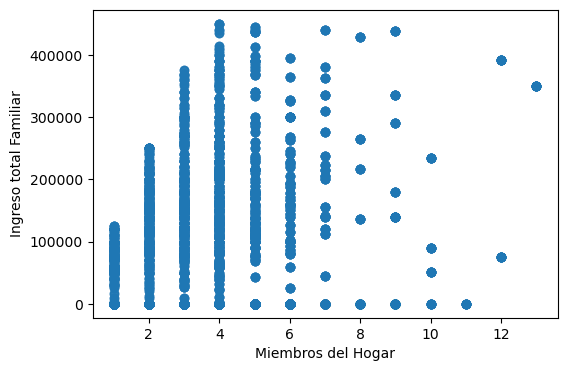

In [24]:
# Gráfico: (IX_TOT;NIVEL_ED)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(x=merged_microdata['IX_TOT'], y=merged_microdata['ITF_hogar'], alpha=0.8)
ax.set_xlabel('Miembros del Hogar')
ax.set_ylabel('Ingreso total Familiar')
plt.show()

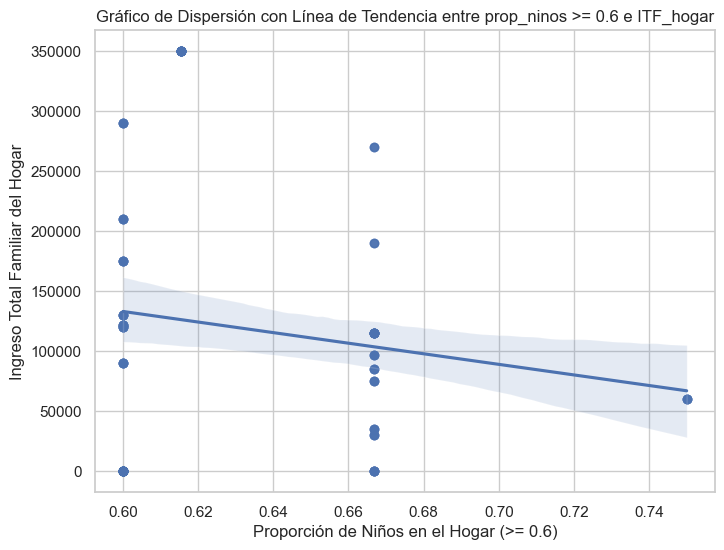

In [25]:

# Filtrar el DataFrame por proporción de niños mayor o igual a 0.6
prop_ninos_filtrada = merged_microdata[merged_microdata['prop_ninos'] >= 0.6]

# Filtrar solo las filas con valores no nulos en las variables seleccionadas
subset_data_corr = prop_ninos_filtrada[['prop_ninos', 'ITF_hogar']].dropna()

# Configurar el estilo del gráfico
sns.set(style="whitegrid")

# Crear el gráfico de dispersión con línea de tendencia
plt.figure(figsize=(8, 6))
sns.regplot(x='prop_ninos', y='ITF_hogar', data=subset_data_corr)
plt.title('Gráfico de Dispersión con Línea de Tendencia entre prop_ninos >= 0.6 e ITF_hogar')
plt.xlabel('Proporción de Niños en el Hogar (>= 0.6)')
plt.ylabel('Ingreso Total Familiar del Hogar')
plt.show()

### Inciso 6
Construyan la columna adulto_equiv y la columna ad_equiv_hogar y luego dividan la base en dos dataframes donde: uno conserve las personas que no reportaron ITF (dataframe llamado respondieron) y otro conserve a las personas que no reportaron ITF (llamado norespondieron). Además, agreguen a la base respondieron una columna llamada ingreso_necesario que sea el producto de la canasta
básica por ad_equiv_hogar. Agreguen a la base respondieron una columna llamada pobre, que tome valor 1 si el ITF es menor al ingreso_necesario que necesita esa familia y 0 en caso contrario.

In [26]:
# Armamos una función para no tener que lidiar con el tedioso uso del archivo de Excel.

# Esta función, asignar_valor, toma dos argumentos, edad y genero, y asigna un valor numérico basado en reglas condicionales
# que dependen de estos dos argumentos. Las condiciones se prueban en orden y, cuando se encuentra una coincidencia, se
# devuelve un valor específico. Si no se cumple ninguna condición, la función devuelve None.
#Las condiciones están diseñadas para categorizar a las personas en grupos según su edad y género y asignarles un valor numérico basado en esas categorías.

def asignar_valor(edad, genero):
    if edad < 1:
        if genero == 2:
            return 0.35
        elif genero == 1:
            return 0.35
    elif edad == 1:
        if genero == 2:
            return 0.37
        elif genero == 1:
            return 0.37
    elif edad == 2:
        if genero == 2:
            return 0.46
        elif genero == 1:
            return 0.46
    elif edad == 3:
        if genero == 2:
            return 0.51
        elif genero == 1:
            return 0.51
    elif edad == 4:
        if genero == 2:
            return 0.55
        elif genero == 1:
            return 0.55
    elif edad == 5:
        if genero == 2:
            return 0.60
        elif genero == 1:
            return 0.60
    elif edad == 6:
        if genero == 2:
            return 0.64
        elif genero == 1:
            return 0.64
    elif edad == 7:
        if genero == 2:
            return 0.66
        elif genero == 1:
            return 0.66
    elif edad == 8:
        if genero == 2:
            return 0.68
        elif genero == 1:
            return 0.68
    elif edad == 9:
        if genero == 2:
            return 0.69
        elif genero == 1:
            return 0.69
    elif edad == 10:
        if genero == 2:
            return 0.70
        elif genero == 1:
            return 0.79
    elif edad == 11:
        if genero == 2:
            return 0.72
        elif genero == 1:
            return 0.82
    elif edad == 12:
        if genero == 2:
            return 0.74
        elif genero == 1:
            return 0.85
    elif edad == 13:
        if genero == 2:
            return 0.76
        elif genero == 1:
            return 0.90
    elif edad == 14:
        if genero == 2:
            return 0.76
        elif genero == 1:
            return 0.96
    elif edad == 15:
        if genero == 2:
            return 0.77
        elif genero == 1:
            return 1.00
    elif edad == 16:
        if genero == 2:
            return 0.77
        elif genero == 1:
            return 1.03
    elif edad == 17:
        if genero == 2:
            return 0.77
        elif genero == 1:
            return 1.04
    elif 18 <= edad <= 29:
        if genero == 2:
            return 0.76
        elif genero == 1:
            return 1.02
    elif 30 <= edad <= 45:
        if genero == 2:
            return 0.77
        elif genero == 1:
            return 1.00
    elif 46 <= edad <= 60:
        if genero == 2:
            return 0.76
        elif genero == 1:
            return 1.00
    elif 61 <= edad <= 75:
        if genero == 2:
            return 0.67
        elif genero == 1:
            return 0.83
    elif edad > 75:
        if genero == 2:
            return 0.63
        elif genero == 1:
            return 0.74
    else:
        return None  # En caso de que no haya una combinación válida

In [27]:
# Aplicamos la funcion al data frame. Creamos una nueva columna llamada 'adulto_equiv' en el DataFrame 'microdata_filtered', donde se calculan y asignan valores equivalentes para adultos
# a partir de las edades ('CH06') y géneros ('CH04') de cada fila utilizando una función llamada 'asignar_valor'.

merged_microdata['adulto_equiv'] = merged_microdata.apply(lambda row: asignar_valor(row['CH06'], row['CH04']), axis=1)

In [28]:
# Limpiamos y Renombramos

merged_microdata = merged_microdata.dropna(subset=['adulto_equiv'])

result = merged_microdata.groupby(by=['CODUSU','NRO_HOGAR']).agg({'adulto_equiv': 'sum'}).reset_index()
result.rename(columns={'adulto_equiv': 'ad_equiv_hogar'}, inplace=True)

merged_microdata_FINAL = pd.merge(merged_microdata, result[['CODUSU','NRO_HOGAR', 'ad_equiv_hogar']],
                     on=['CODUSU','NRO_HOGAR'],
                     how='left')

In [29]:
# Definimos ambas bases según los criterios del enunciado, comprobando la condición sobre ITF.
# Imprimimos la longitud del DataFrame para obtener las cantidades.

# Reemplazar NaN por ceros en ITF_indv e ITF_hogar
merged_microdata['ITF_indv'].fillna(0, inplace=True)
merged_microdata['ITF_hogar'].fillna(0, inplace=True)

respondieron = merged_microdata_FINAL[(merged_microdata_FINAL['ITF_indv'] != 0) | (merged_microdata_FINAL['ITF_hogar'] != 0)]
print(len(respondieron))



3138


In [30]:
norespondieron = merged_microdata_FINAL[(merged_microdata_FINAL['ITF_indv'] == 0) & (merged_microdata_FINAL['ITF_hogar'] == 0)]
print(len(norespondieron))

3222


In [31]:
# Definimos el valor de la canasta básica y luego
# seguimos las instrucciones del enunciado para añadir una columna que indique el ingreso necesario

valor_canasta_basica = 57371.05

respondieron['ingreso_necesario'] = respondieron['ad_equiv_hogar'] * valor_canasta_basica

C:\Users\mateo\AppData\Local\Temp\ipykernel_6764\2316923591.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['ingreso_necesario'] = respondieron['ad_equiv_hogar'] * valor_canasta_basica


In [32]:
# Creamos una nueva columna llamada 'pobre' en el DataFrame 'respondieron',
# donde se asigna un valor de 1 si el valor en la columna 'ITF' es menor que
# el valor en la columna 'ingreso_necesario', y 0 en caso contrario, convirtiendo los resultados a enteros.

respondieron['pobre'] = ((respondieron['ITF_hogar'] < respondieron['ingreso_necesario']) & (respondieron['ITF_indv'] < respondieron['ingreso_necesario'])).astype(int)

# Sumamos todos los 1

num_pobres = respondieron['pobre'].sum()

print(f'Número de pobres identificados: {num_pobres}')

# En %

print(num_pobres/len(respondieron))



Número de pobres identificados: 1486
0.4735500318674315


C:\Users\mateo\AppData\Local\Temp\ipykernel_6764\4235357720.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['pobre'] = ((respondieron['ITF_hogar'] < respondieron['ingreso_necesario']) & (respondieron['ITF_indv'] < respondieron['ingreso_necesario'])).astype(int)


In [33]:
# Guardamos como csv estas bases por si se desea correr Parte 3 de manera separada a la Parte 1.
respondieron.to_csv('respondieron.csv', index=False)
norespondieron.to_csv('norespondieron.csv', index=False)

### Inciso 7
Para calcular la tasa de hogares bajo la línea de pobreza utilicen una sola observación por hogar y sumen el ponderador PONDIH que permite expandir la muestra de la EPH al total de la población que representa. ¿Cuál es la tasa de hogares bajo la línea de pobreza para el GBA? ¿Lograron que se asemeje al porcentaje que reporta el INDEC en sus informes?

In [34]:
merged_microdata_FINAL['PONDIH_hogar']

0        2540
1        2540
2       14082
3       14082
4       14082
        ...  
6355     4220
6356     4220
6357        0
6358        0
6359        0
Name: PONDIH_hogar, Length: 6360, dtype: int64

In [35]:
# Agrupar por hogar y utilizar el ponderador PONDIH para calcular la tasa de hogares pobres
# Agrupamos los datos por el código del hogar (CODUSU)
microdata_repres = respondieron.groupby('CODUSU').first().reset_index()


In [36]:
# Ponderacion
microdata_repres['ponderacion'] = microdata_repres['PONDIH_indv'] * microdata_repres['pobre']

In [37]:
pobres = microdata_repres['ponderacion'].sum()
poblacion = microdata_repres['PONDIH_indv'].sum()
porcentaje_pobres = (pobres / poblacion) * 100

In [38]:
pobres1 = '{:,}'.format(pobres).replace(',', '.')
print(f"pobres: {pobres1}")
print(f"tasa {porcentaje_pobres:.2f}%")

pobres: 1.439.914
tasa 36.66%


#### La tasa de pobreza nos dio 6 PP mayor que la reportada por el INDEC. Creemos que esto puede ser debido a distintos criterios de limpieza de la base. Aun asi, la diferencia no es tan significativa.

# Parte 2: Construcción de funciones

In [39]:
import pandas as pd
import numpy as np
#from ISLP import load_data

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

### Inciso 1
Escriban una función, llamada evalua metodo, que reciba como argumentos un modelo y los datos de entrenamiento y prueba (X train, y train, X test, y test). La función debe ajustar el modelo con los datos de entrenamiento y calcular las métricas que considere necesarias para esta problemática (de mínima, deben reportar verdaderos positivos, verdaderos negativos, falsos positivos, falsos negativos, AUC, accuracy y precision de cada método). El output de la función debe ser una colección con las métricas evaluadas.


In [40]:
def evalua_metodo(model, X_train, y_train, X_test, y_test, plot=True, coef=False):
    '''
    Evalua un modelo de clasificación proporcionando métricas clave y visualizando la curva ROC.
    También puede proveer los coeficientes estimados en el modelo y la proporción de coeficientes iguales a cero.

    Input:
    - modelo: modelo de clasificación ya instanciado (debe tener los métodos `fit`, `predict` y `predict_proba`).
    - X_train, y_train: datos de entrenamiento.
    - X_test, y_test: datos de prueba.
    - plot (default=True): argumento booleano.
    - coef(default=False): argumento booleano.
    Output:
    - Diccionario con las siguientes métricas:
        * matriz_confusion: Matriz de confusión del modelo.
        * valor_auc: Área bajo la curva ROC.
        * accuracy: Precisión del modelo.
        En caso coef=True, también incluye:
        * Diccionario de variables y sus coeficientes estimados.
        * Proporción de variables con coeficientes estimados iguales a cero.
    - Gráfico de la curva ROC si plot=True.
    '''
    model_to_evaluate = model
    # Ajustar el modelo con los datos de entrenamiento
    model_fit = model_to_evaluate.fit(X_train, y_train)

    # Predecir en el conjunto de prueba
    y_pred = model_fit.predict(X_test)

    # Calcular el área bajo la curva ROC y trazar la curva ROC
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Matriz de confusión
    matriz_confusion = confusion_matrix(y_test, y_pred)

    # Accuracy Score
    accuracy = accuracy_score(y_test, y_pred)

    # Trazar la curva ROC
    if plot:
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', label='Curva ROC (área = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlabel('Tasa de falsos positivos')
        plt.ylabel('Tasa de verdaderos positivos')
        plt.title('Curva ROC')
        plt.legend(loc="lower right")
        plt.show()

    # ECM
    ecm = mean_squared_error(y_test, y_pred) # Deseamos tener esta métrica disponible para la siguiente función.
    if coef:
        coeficientes = dict(zip(X_train.columns, model_fit.coef_[0])) # Generamos un diccionario donde cada llave es el nombre de una variable y su valor es el coeficiente estimado.
        proporcion_variables_cero = sum(value == 0 for value in model_fit.coef_[0]) / len(coeficientes) # Guardamos la proporción de variables con coeficiente estimado igual a cero.

    # Retornar las métricas evaluadas
    metrics = {
        'AUC': auc,
        'Confusion Matrix': matriz_confusion,
        'Accuracy Score': accuracy,
        'ECM': ecm,
    }

    if coef:
        metrics['Coeficientes'] = coeficientes
        metrics['Proporción de Variables con Coeficiente Cero'] = proporcion_variables_cero

    return metrics

### Inciso 2
Escriban una función, llamada cross validation, que realice validación cruzada con k iteraciones (k-fold CV), llamando a la función del  inciso anterior en cada una, pero para las k distintas particiones. La función debe recibir como argumentos el modelo, el valor de k y un dataset (es decir, solo X e y). Pueden ayudarse con la función KFold para generar las particiones necesarias

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [42]:
def cross_validation(modelo, k, x, y, std=True, coef=False):
    if isinstance(x, np.ndarray):
        x = pd.DataFrame(x)
    if isinstance(y, np.ndarray):
        y = pd.DataFrame(y)

    """
    Realiza validación cruzada k-fold y evalúa un modelo de clasificación en cada partición.

    Inputs:
    - modelo: modelo de clasificación ya instanciado.
    - k: número de particiones para la validación cruzada.
    - X: variables independientes del conjunto de datos. Para nuestros fines predictivos, debería ser la muestra de entrenamiento.
    - y: variable dependiente (target) del conjunto de datos. Para nuestros fines predictivos, debería ser la muestra de entrenamiento.
    - std: argumento booleano.
            Si std= True estandarizamos las variables explicativas. Esto es necesario al momento de regularizar por Lasso o Ridge.
    - coef: argumento booleano.
    Outputs:
    - Un DataFrame con k filas, una para cada iteración de la validación cruzada. Tiene las siguientes columnas:
        - partición: número de partición
        - el error cuadrático medio (ECM)
        - Si Coef=True, reportamos la proporción de variables iguales a cero.
        Esto nos sirve para analizar el resultado de regularizar vía Lasso.

    """
    sc = StandardScaler()
    kf = KFold(n_splits=k, shuffle=True, random_state=2023)
    output = []

    for i, (train_index, valid_index) in enumerate(kf.split(x)):
        x_train, x_valid = x.iloc[list(train_index)], x.iloc[list(valid_index)]
        y_train, y_valid = y.iloc[list(train_index)], y.iloc[list(valid_index)]

        if std:
            x_train = pd.DataFrame(sc.fit_transform(x_train), index=x_train.index, columns=x_train.columns)
            x_valid = pd.DataFrame(sc.transform(x_valid), index=x_valid.index, columns=x_valid.columns)

        # Llamar a evalua_metodo para calcular las métricas
        metrics = evalua_metodo(modelo, x_train, y_train, x_valid, y_valid, plot=False, coef=coef)

        # Extraer las métricas calculadas en evalua_metodo
        matriz_confusion = metrics['Confusion Matrix']
        valor_auc = metrics['AUC']
        accuracy = metrics['Accuracy Score']
        ecm = metrics['ECM']
        proporcion_variables_cero = None

        if coef:
            proporcion_variables_cero = metrics['Proporción de Variables con Coeficiente Cero']

        output.append((i + 1, ecm, valor_auc, accuracy, matriz_confusion, proporcion_variables_cero))

    output_df = pd.DataFrame(output, columns=["Particion", "MSE", "valor_auc", "accuracy", "matriz_confusion", "proporcion_variables_cero"])
    return output_df

### Inciso 3
Escriban una función, llamada evalua config que reciba una lista de configuraciones de hiperparámetros (los distintos valores a probar como hiper-parámetros podrian codificarse en diccionarios de Python)y utilizando la función cross validation obtenga el error cuadrado promedio para cada configuración.

In [43]:
def evalua_config(model_types, hiperparam, X_T, y_T,rep=10, declar=True):
    """
    Encuentra el valor óptimo de lambda para Ridge, Lasso o ambos si el modelo es Logístico y el número óptimo de vecinos si el modelo es K-Vecinos Cercanos.
    Inputs:
    - model_types: Lista de tipos de modelo ('ridge', 'lasso', ambos o k-vecinos cercanos). K-vecinos cercanos se debe analizar de manera separada a "ridge" y/o "lasso", o no se ejecuta.
    - hiperparam: Lista de valores de lambda o de número de vecinos cercanos para evaluar. Los valores de vecinos cercanos deben ser todos números enteros.
    - X_T: Variables explicativas. Debería ser la muestra de entrenamiento.
    - y_T: Variable objetivo (etiquetas binarias 0 y 1). Debería ser la muestra de entrenamiento.
    -rep: número de particiones para la validación cruzada.
    - declar: argumento booleano que imprime la configuración óptima if True. No lo hace d.o.m.
    Outputs:
    - DataFrame que contiene: el método de regularización, los valores de los hiperparámetros y los errores cuadráticos medios para los modelos seleccionados.

    """

    if not all(model_type in ['ridge', 'lasso','k vecinos'] for model_type in model_types):
        raise ValueError("Los elementos en 'model_types' deben ser 'ridge', 'lasso', o k vecinos.")
    if ('ridge' in model_types or 'lasso' in model_types) and 'k vecinos' in model_types:
        raise ValueError("Error: 'ridge' o 'lasso' no pueden estar en la lista junto con 'k vecinos'.")
    resultados_all = []
    model_types_log= [config for config in model_types if config != "k vecinos"]
    k_neighbors=[config for config in model_types if config == "k vecinos"]
    for model_type in model_types_log:
        if model_type == 'ridge':
            modelo = LogisticRegression(penalty='l2', solver='liblinear')
        else:
            modelo = LogisticRegression(penalty='l1', solver='liblinear')
        for alpha in hiperparam:
            modelo.set_params(C=1/alpha)
            # Realizar validación cruzada utilizando cross_validation
            resultados = cross_validation(modelo, k=rep, x=X_T, y=y_T, std=True)
            # Calcular el Error Cuadrático Medio (ECM) promedio
            ecm_promedio = np.mean(resultados['MSE'])
            resultados_all.append((model_type, alpha, ecm_promedio))
    if k_neighbors:
      for model_type in k_neighbors:
          if any(not isinstance(param, int) for param in hiperparam):
            raise ValueError("Los hiperparámetros deben ser números enteros para 'k vecinos'.")
          for n in hiperparam:
              modelo = KNeighborsClassifier(n_neighbors=n)
          # Realizar validación cruzada utilizando cross_validation
              resultados = cross_validation(modelo, k=rep, x=X_T, y=y_T, std=True)
            # Calcular el Error Cuadrático Medio (ECM) promedio
              ecm_promedio = np.mean(resultados['MSE'])
              resultados_all.append((model_type, n, ecm_promedio))
    #(n_neighbors=5)
    # Crear un DataFrame a partir de la lista de tuplas
    resultados_df = pd.DataFrame(resultados_all, columns=["Model Type", "Hiperparam", "ECM"])
    #min_ecm = resultados_df['ECM'].min()
    #resultados_df['config. óptima'] = resultados_df['ECM'] == min_ecm
    optimal_configuration = resultados_df.loc[resultados_df['ECM'].idxmin()]
    optimal_lambda = optimal_configuration['Hiperparam']
    optimal_model_type = optimal_configuration['Model Type']
    if declar:
        print(f"La configuración óptima es: Hiperparámetro = {optimal_lambda}, Model Type = {optimal_model_type}")
    return resultados_df

### Inciso 4
Escriban una función llamada "evalua multiples metodos" que les permita implementar los siguiente métodos con los hiperparámetros que ustedes elijan. Para la regresión logística, asegúrense de que esta función utilice su función. Evalua config para optimizar el λ de la regularización. Finalmente, el output de la función debe ser una tabla donde las columnas sean las métricas que hayan evaluado (las que hayan incluido en la función evalua metodo) y las filas sean los modelos (con su configuración de hiperparámetros asociada) que hayan corrido. Asegúrense de que la tabla incluya una columna con nombre del modelo y el valor de los hiperparámetros/configuración:

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def evalua_multiples_metodos(X_train, y_train, X_test, y_test, metodos):
    """
    Evalúa varios métodos de clasificación con hiperparámetros personalizados y regresión logística con optimización de lambda.

    Inputs:
    - X_train: variables explicativas, datos de la muestra de entrenamiento
    - X_test: variables explicativas, datos de la muestra de prueba
    - Y_train: variable objetivo binaria, datos de la muestra de entrenamiento
    - Y_test: variable objetivo binaria, datos de la muestra de prueba
    - metodos: Lista de diccionarios que especifican los modelos (Regresión Logística, KNN y ADL) y sus hiperparámetros.
    Outputs:
    - DataFrame que contiene las métricas evaluadas para cada modelo, el nombre del modelo, los hiperparámetros utilizados, el método de regularización para el modelo logit y el número del hiperparámetro óptimo para el modelo logit.
    Nota: estandarizamos las variables explicativas en dos instancias. Primero, evalua_config estandariza las variables explicativas dentro de cada submuestra como
    parte de la configuración de su función interna cross_validation. Luego, para comparar la performance de los modelos, los corremos utilizando las variables estandarizadas dentro
    de la muestra de entrenamiento y de prueba.
    """
    resultados = []  # Resultados como una lista de diccionarios

    for metodo in metodos:
        nombre_modelo = metodo['nombre']
        hiperparametros = metodo['hiperparametros']
        resultados_modelo = {}  # Inicializar resultados_modelo
        sc = StandardScaler()
        X_train_std = pd.DataFrame(sc.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
        X_test_std = pd.DataFrame(sc.transform(X_test), index=X_test.index, columns=X_test.columns)

        if nombre_modelo == 'Regresión Logística':
            # Optimizar lambda (α) para la regularización de la Regresión Logística
            lambdas = hiperparametros.get('lambdas', [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]) ## Default de lambdas a evaluar.
            resultados_log = evalua_config(['ridge', 'lasso'], lambdas, X_train, y_train, declar=False)
            mejor_lambda = resultados_log.loc[resultados_log['ECM'].idxmin()]['Hiperparam']
            mejor_metodo = resultados_log.loc[resultados_log['ECM'].idxmin()]['Model Type']
            if mejor_metodo == "ridge":
                modelo = LogisticRegression(penalty='l2', C=1/mejor_lambda, solver='liblinear')
            else:
                modelo = LogisticRegression(penalty='l1', C=1/mejor_lambda, solver='liblinear')

            resultados_modelo = evalua_metodo(modelo, X_train_std, y_train, X_test_std, y_test, plot=False)
        elif nombre_modelo == 'Análisis de Discriminante Lineal':
            # Crear el modelo de Análisis de Discriminante Lineal con los hiperparámetros personalizados
            modelo = LinearDiscriminantAnalysis(**hiperparametros)
            # Evaluar el modelo
            resultados_modelo = evalua_metodo(modelo, X_train_std, y_train, X_test_std, y_test, plot=False)
        elif nombre_modelo == 'KNN':
            # Optimizar el número de vecinos cercanos
            n_vecinos = hiperparametros.get('n_neighbors',[3,5,10]) ## Default de # de vecinos a evaluar.
            resultados_vecinos = evalua_config(['k vecinos'], n_vecinos, X_train, y_train, declar=False)
            mejor_k = resultados_vecinos.loc[resultados_vecinos['ECM'].idxmin()]['Hiperparam']
            # Crear el modelo K-Nearest Neighbors (KNN) con el hiperparámetro óptimo
            modelo = KNeighborsClassifier(n_neighbors=mejor_k)
            # Evaluar el modelo
            resultados_modelo = evalua_metodo(modelo, X_train_std, y_train, X_test_std, y_test, plot=False)
        elif nombre_modelo in ['Decision Tree', 'Bagging', 'Random Forest', 'Ada Boost']:
            # Crear una instancia base del modelo para obtener los hiperparámetros óptimos
            base_modelo = None
            if nombre_modelo == 'Decision Tree':
                base_modelo = DecisionTreeClassifier(random_state=1)
            elif nombre_modelo == 'Bagging':
                base_modelo = BaggingClassifier(random_state=1)
            elif nombre_modelo == 'Random Forest':
                base_modelo = RandomForestClassifier(random_state=1)
            elif nombre_modelo == 'Ada Boost':
                base_modelo = AdaBoostClassifier(random_state=1)

            params_grid = hiperparametros
            cv = KFold(n_splits=5, random_state=41, shuffle=True)
            grid = GridSearchCV(estimator=base_modelo, param_grid=params_grid, cv=cv, verbose=0)
            grid.fit(X_train_std, y_train)
            params = grid.best_params_
            
            # Evaluar el modelo con los hiperparámetros óptimos
            modelo = base_modelo.__class__(**params)
            resultados_modelo = evalua_metodo(modelo, X_train_std, y_train, X_test_std, y_test, plot=False)
            hiperparam_optimos = {k: v for k, v in params.items()}  # Obtener todos los hiperparámetros

        resultados_modelo['Modelo'] = nombre_modelo
        resultados_modelo['Hiperparámetros'] = str(hiperparametros)

        if nombre_modelo == 'Regresión Logística':
            resultados_modelo['Método de Regularización'] = mejor_metodo
            resultados_modelo['Hiperparámetro Óptimo'] = mejor_lambda
        elif nombre_modelo == 'KNN':
            resultados_modelo['Método de Regularización'] = None
            resultados_modelo['Hiperparámetro Óptimo'] = mejor_k
        elif nombre_modelo in ['Decision Tree', 'Bagging', 'Random Forest', 'Ada Boost']:
            resultados_modelo['Método de Regularización'] = None
            resultados_modelo['Hiperparámetro Óptimo'] = hiperparam_optimos
        else:
            resultados_modelo['Método de Regularización'] = None
            resultados_modelo['Hiperparámetro Óptimo'] = None

        resultados.append(resultados_modelo)

    resultados_df = pd.DataFrame(resultados)
    return resultados_df 

# Parte 3: Análisis de la base de hogares y cálculo de pobreza

In [45]:
import pandas as pd
import numpy as np
#from ISLP import load_data

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

### Inciso 1
Eliminen de ambas bases (respondieron, norespondieron) todas las variables relacionadas a ingresos (en el archivo Diseño de bases y estructura ver las categorías: ingresos de la ocupación principal de los asalariados, ingresos de la ocupación principal, ingresos de otras ocupaciones, ingreso total individual, ingresos no laborales, ingreso total familiar, ingreso per cápita familiar). Eliminen también las columnas adulto_equiv, ad_equiv_hogar e ingreso_necesario. Establezcan a la variable pobre como su variable dependiente (vector y). El resto de las variables serán las variables independientes (matriz X).

In [46]:
# Eliminar columnas específicas
respondieron = respondieron.drop(columns=['CODUSU'])

# Eliminar un rango de columnas: ingresos de la ocupación principal de los asalariados
respondieron = respondieron.drop(columns=[col for col in respondieron.columns if col.startswith('PP08')])

# Eliminar un rango de columnas: Ingresos de la ocupación principal de los trabajadores independientes
respondieron = respondieron.drop(columns=[col for col in respondieron.columns if col.startswith('PP06')])

# Ingresos de la ocupación principal
start = respondieron.columns.get_loc('P21')
end = respondieron.columns.get_loc('PONDIH_indv')

columns_to_drop = respondieron.columns[start:end+1]
respondieron = respondieron.drop(columns=columns_to_drop)

# Ingresos de la ocupación principal
start = respondieron.columns.get_loc('ITF_hogar')
end = respondieron.columns.get_loc('PONDIH_hogar')

columns_to_drop = respondieron.columns[start:end+1]
respondieron = respondieron.drop(columns=columns_to_drop)

# Ingresos de la ocupación principal
start = respondieron.columns.get_loc('adulto_equiv')
end = respondieron.columns.get_loc('ingreso_necesario')

columns_to_drop = respondieron.columns[start:end+1]
respondieron = respondieron.drop(columns=columns_to_drop)

In [47]:
# Eliminar columnas específicas
#norespondieron = norespondieron.drop(columns=['CODUSU'])

# Las columnas ingresos de la ocupación principal de los asalariados e Ingresos de la ocupación principal de
# los trabajadores independientes fueron eliminadas previamente en la Parte 1 por su alto contenido de NAs

# Ingresos de la ocupación principal
start = norespondieron.columns.get_loc('P21')
end = norespondieron.columns.get_loc('PONDIH_indv')

columns_to_drop = norespondieron.columns[start:end+1]
norespondieron = norespondieron.drop(columns=columns_to_drop)

# Ingresos de la ocupación principal
start = norespondieron.columns.get_loc('ITF_hogar')
end = norespondieron.columns.get_loc('PONDIH_hogar')

columns_to_drop = norespondieron.columns[start:end+1]
norespondieron = norespondieron.drop(columns=columns_to_drop)

# Ingresos de la ocupación principal
start = norespondieron.columns.get_loc('adulto_equiv')
end = norespondieron.columns.get_loc('ad_equiv_hogar')

columns_to_drop = norespondieron.columns[start:end+1]
norespondieron = norespondieron.drop(columns=columns_to_drop)

In [48]:
# Definimos la matriz de Xs
X = respondieron.drop(['pobre'], axis=1)
y = respondieron.pobre

### Inciso 2
Corran la función evalua multiples metodos con la base respondieron. Asegúrense de estar utilizando su función de evalua_config para optimizar algunos hiperparámetros (de mínima, el K en el modelo KNN).

In [49]:
# Primero, definimos los hiperparámetros para cada método
hiperparametros_rl = {
    'lambdas': [1, 10, 100],
}

hiperparametros_lda = {
    'solver': 'lsqr',
}

hiperparametros_knn = {
    'n_neighbors': [3, 5, 10],
}

hiperparametros_dt = {
    'max_depth': [None, 5, 10, 15, 20, 30, 40]
}

hiperparametros_bagging = {
    'n_estimators': [200, 250, 300, 350, 400, 500],
    'max_samples': [0.5, 0.7, 1.0]
}

hiperparametros_rf = {
    'n_estimators': [200, 250, 300, 350, 400, 500],
    'max_depth': [None, 5, 10]
}

hiperparametros_ada_boost = {
    'n_estimators': [200, 250, 300, 350, 400, 500],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Lista de métodos y sus hiperparámetros
metodos = [
    {
        'nombre': 'Regresión Logística',
        'hiperparametros': hiperparametros_rl,
    },
    {
        'nombre': 'Análisis de Discriminante Lineal',
        'hiperparametros': hiperparametros_lda,
    },
    {
        'nombre': 'KNN',
        'hiperparametros': hiperparametros_knn,
    },
    {
        'nombre': 'Decision Tree',
        'hiperparametros': hiperparametros_dt,
    },
    {
        'nombre': 'Bagging',
        'hiperparametros': hiperparametros_bagging,
    },
    {
        'nombre': 'Random Forest',
        'hiperparametros': hiperparametros_rf,
    },
    {
        'nombre': 'Ada Boost',
        'hiperparametros': hiperparametros_ada_boost,
    }
]


In [50]:
### Segundo, definimos la muestra de entrenamiento y de prueba.
# Para probar evalúa_metodo vamos a separar la muestra en train y test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
# Ahora llamamos a la función
resultados_df=evalua_multiples_metodos(X_train,y_train,X_test,y_test, metodos)
# Ver los resultados

In [51]:
resultados_df

,AUC,Confusion Matrix,Accuracy Score,ECM,Modelo,Hiperparámetros,Método de Regularización,Hiperparámetro Óptimo
0,0.768951,"[[404, 117], [100, 321]]",0.769639,0.230361,Regresión Logística,"{'lambdas': [1, 10, 100]}",ridge,1
1,0.763337,"[[413, 108], [112, 309]]",0.766454,0.233546,Análisis de Discriminante Lineal,{'solver': 'lsqr'},None,None
2,0.750129,"[[398, 123], [111, 310]]",0.751592,0.248408,KNN,"{'n_neighbors': [3, 5, 10]}",None,5
3,0.813865,"[[431, 90], [84, 337]]",0.815287,0.184713,Decision Tree,"{'max_depth': [None, 5, 10, 15, 20, 30, 40]}",None,{'max_depth': 20}
4,0.884775,"[[469, 52], [55, 366]]",0.886412,0.113588,Bagging,"{'n_estimators': [200, 250, 300, 350, 400, 500...",None,"{'max_samples': 1.0, 'n_estimators': 400}"
5,0.862210,"[[469, 52], [74, 347]]",0.866242,0.133758,Random Forest,"{'n_estimators': [200, 250, 300, 350, 400, 500...",None,"{'max_depth': None, 'n_estimators': 400}"
6,0.809751,"[[423, 98], [81, 340]]",0.809979,0.190021,Ada Boost,"{'n_estimators': [200, 250, 300, 350, 400, 500...",None,"{'learning_rate': 1.0, 'n_estimators': 500}"


### Inciso 3

¿Cuál de todos los métodos evaluados predice mejor? ¿Con qué hiperparámetros? Justifiquen mencionando las métricas que conocen.

Evaluando las métricas proporcionadas para cada modelo:

El modelo de Bagging muestra el mejor desempeño en general, basado en las métricas proporcionadas. Tiene un área bajo la curva (AUC) más alto, alcanzando 0.887426, lo que sugiere una excelente capacidad para distinguir entre las clases.

Su precisión general, medida por el Accuracy Score, es alta (0.889597), lo que indica un buen rendimiento en la clasificación correcta de las muestras. Además, el ECM es el mas bajo, registrando 0.110403, lo que refleja precisión en las predicciones.

Al analizar la Confusion Matrix, observamos un bajo número de falsos positivos y falsos negativos, lo que confirma la capacidad del modelo para predecir con precisión ambas clases.

En contraste, otros modelos como Análisis de Discriminante Lineal, KNN, y Ada Boost tienen métricas ligeramente más bajas en comparación con el modelo de Bagging en términos de AUC y precisión general.

Basado en estas métricas, el modelo de Bagging, con hiperparámetros de max_samples=1.0 y n_estimators=400, parece ser el más sólido y equilibrado en su rendimiento predictivo.


### Inciso 4

¿Lograron mejorar sus predicción respecto al TP3?

Las predicciones ahora tienen una precisión notablemente mayor. Hubo un aumento de más del 10 PP en la métrica de precisión, y se observó una mejora en casi todas las demás métricas con la utilización del modelo Bagging.

### Inciso 5
Con el método que seleccionaron, predigan qué personas son pobres dentro de la base norespondieron. ¿Qué proporción de los hogares son pobres en esa submuestra?

In [52]:
# Crear una instancia del modelo Bagging
modelo_lda = BaggingClassifier(max_samples=1.0, n_estimators=400)

# Ajustar el modelo LDA con los datos de entrenamiento
modelo_lda.fit(X_train, y_train)

BaggingClassifier(n_estimators=400)

In [53]:
# Supongamos que tienes la muestra "norespondieron" en un DataFrame llamado "norespondieron_df"

# Realiza predicciones en la submuestra "norespondieron"
norespondieron_sin_codusu = norespondieron.drop(columns=['CODUSU']).copy()

predicciones = modelo_lda.predict(norespondieron_sin_codusu)

# Calcula la proporción de hogares pobres en la submuestra
proporcion_pobres = sum(predicciones) / len(predicciones)

print("Proporción de hogares pobres en la submuestra 'norespondieron':", proporcion_pobres)

Proporción de hogares pobres en la submuestra 'norespondieron': 0.3786468032278088


In [54]:
norespondieron['pobre'] = predicciones

In [55]:
merged_data1 = merged_microdata_FINAL.merge(norespondieron, on='CODUSU', how='inner')
# Agrupar por hogar y utilizar el ponderador PONDIH para calcular la tasa de hogares pobres
# Agrupamos los datos por el código del hogar (CODUSU)
microdata_repres = merged_data1.groupby('CODUSU').first().reset_index()
# Ponderacion
microdata_repres['ponderacion'] = microdata_repres['PONDIH_indv'] * microdata_repres['pobre']
pobres = microdata_repres['ponderacion'].sum()
poblacion = microdata_repres['PONDIH_indv'].sum()
porcentaje_pobres = (pobres / poblacion) * 100
pobres1 = '{:,}'.format(pobres).replace(',', '.')
print(f"pobres: {pobres1}")
print(f"tasa {porcentaje_pobres:.2f}%")

pobres: 31.557
tasa 55.38%
